In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb


In [18]:
df = pd.read_excel('../../data_set/hd_sessions/cleaned_session_data.xlsx')

# 2. Create the target: Next session's dry weight - current dry weight
df['Next Dry weight (kg)'] = df.groupby('Subject_ID')['Dry weight (kg)'].shift(-1)
df['Dry weight adjustment (kg)'] = df['Next Dry weight (kg)'] - df['Dry weight (kg)']

# 3. Drop rows where the target is NaN (i.e., last session for a patient)
df = df.dropna(subset=['Dry weight adjustment (kg)']).reset_index(drop=True)

# Features and target
features = [
    'AP (mmHg)', 'AUF (ml)', 'BFR (ml/min)', 'Dry weight (kg)','HD duration (h)',
    'PUF (ml)', 'Post HD weight (kg)', 'Pre HD weight (kg)',
    'TMP (mmHg)', 'VP (mmHg)', 'Weight gain (kg)', 'SYS (mmHg)', 'DIA (mmHg)'
]

target = 'Next Dry weight (kg)'

X = df[features]
y = df[target]


In [19]:
weights = np.where(y == 0, 1, 10)


In [20]:
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, weights, test_size=0.2, random_state=42
)


In [21]:
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train, sample_weight=w_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [22]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("📊 Model Performance Metrics:")
print(f"➡️  Mean Absolute Error (MAE):       {mae:.3f}")
print(f"➡️  Mean Squared Error (MSE):        {mse:.3f}")
print(f"➡️  Root Mean Squared Error (RMSE):  {rmse:.3f}")
print(f"➡️  R² Score:                         {r2:.3f}")


📊 Model Performance Metrics:
➡️  Mean Absolute Error (MAE):       0.179
➡️  Mean Squared Error (MSE):        0.144
➡️  Root Mean Squared Error (RMSE):  0.380
➡️  R² Score:                         0.999


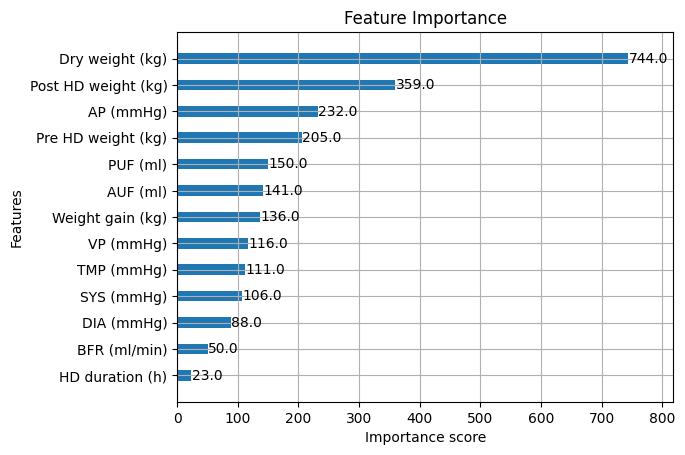

In [24]:
import matplotlib.pyplot as plt

xgb.plot_importance(model, importance_type='weight', height=0.4)
plt.title('Feature Importance')
plt.show()


In [25]:
from sklearn.metrics import mean_absolute_error, r2_score

y_true = y_test  # next session dry weight
y_pred_baseline = X_test['Dry weight (kg)']  # current session dry weight as prediction

print("Baseline MAE:", mean_absolute_error(y_true, y_pred_baseline))
print("Baseline R2:", r2_score(y_true, y_pred_baseline))


Baseline MAE: 0.0597640891218873
Baseline R2: 0.9995814812973157
